# Exploring Midi Data Structure Produced by pianotrans ML Transcription

In [1]:
import json
from functools import reduce
import os
from matplotlib import pyplot as plt
import pandas as pd

# Midi Top Level Fields

In [2]:
# look into saber's edge json, produced by midi-parser-js (https://github.com/colxi/midi-parser-js)
current_folder = globals()['_dh'][0]

with open(os.path.join(current_folder, 'sabers_edge.json')) as f:
    data = json.load(f)

In [3]:
# get top level keys
print("midi json contains the following top level keys:")
for key, value in data.items():
    print(key, end=', ')

midi json contains the following top level keys:
formatType, tracks, track, timeDivision, 

In [4]:
# time division relates deltaTime field in data to real time
print("time division:", data["timeDivision"])

time division: 384


In [5]:
# get sum of deltaTime from midi data, track 1 (which is the longest track, track 0 has only 3 data)
def sum_delta_time(cur_sum, note):
    return cur_sum + int(note["deltaTime"])

track = data['track'][-1]['event']
sum_of_delta_time = reduce(sum_delta_time, track, 0)
print("sum of track -> deltaTime:", sum_of_delta_time)

sum of track -> deltaTime: 117913


### Relating timeDivision and deltaTime to real time:

Midi or atleast pianotrans transcription uses base 120 bpm (2 beats/second).

Taking into account timeDivision which is 384 and 117913 time ticks total, the total length of saber's edge is 117913/(384 * 2) = 153.53 seconds

The original length of saber's edge video/audio is 2min36sec, which accounting for dead time at the start and end does indeed match this information.

Therefore:
Can perform cumulative summation as well as division by timeDivision*2 to get current timestamp

# Midi Data Fields

In [6]:
# convert to format that can be parsed into dataframe
data_for_df = [{"deltaTime": data["deltaTime"],
                "type": data["type"],
                "channel": data["channel"],
                "pitch": data["data"][0],
                "velocity": data["data"][1]}
               for data in track[:-1]] # ignore last data which has no data but instead has MetaType field

sabers_edge_df = pd.DataFrame(data_for_df)
sabers_edge_df.head(5)

,deltaTime,type,channel,pitch,velocity
0,2511,9,0,59,75
1,11,9,0,41,48
2,1,9,0,29,54
3,9,9,0,48,54
4,2,11,0,64,127


In [7]:
# get number of data, is this number of notes??
len(sabers_edge_df)

4508

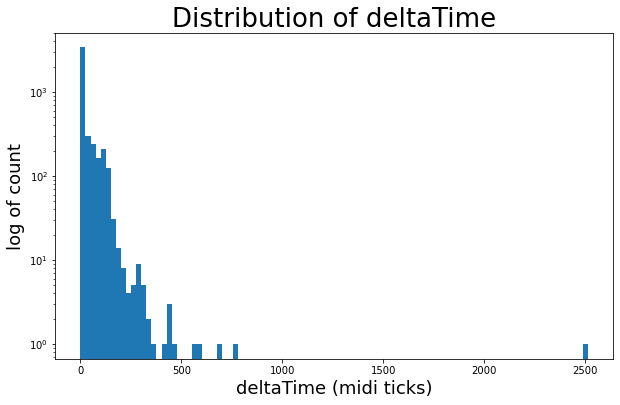

In [8]:
# get distribution of deltaTime, plot log of count since many deltaTime are close to 0
fig = plt.figure(figsize=(10,6))
plt.hist(sabers_edge_df["deltaTime"], bins = 100, log=True)
plt.title("Distribution of deltaTime", fontsize=26)
plt.xlabel('deltaTime (midi ticks)', fontsize=18)
plt.ylabel('log of count', fontsize=18)
plt.show()

In [9]:
# look into distribution of type field
sabers_edge_df.type.value_counts()

9     4284
11     224
Name: type, dtype: int64

In [10]:
# type 11 events seem to have either velocity 127 or velocity 0, seems binary, almost like sustain pedal
sabers_edge_df.loc[sabers_edge_df['type'] == 11].velocity.value_counts()

0      112
127    112
Name: velocity, dtype: int64

### Relating type fields to piano:

According to https://www.mixagesoftware.com/en/midikit/help/HTML/midi_events.html

9 is a 'Note On Event' and 11 is a 'Controller Event'.
Curiously 10, the 'Note Off Event' is not used, investigation further I came across forum posts such as this:
https://forum.cockos.com/showthread.php?t=232615#:~:text=A%20MIDI%20Note%20On%20with,part%20of%20the%20MIDI%20Standard 

They discuss how sometimes rather then using note off events, a note on event with velocity=0 can also encode a note off event. Therefore you will expect an equal amount of data with type=9 and velocity=0 as the amount of data with type=0 and velocity=[1,127]

Controller event seems to indicate sustain pedal events, which is something the original paper described they perform inference on: https://arxiv.org/abs/2010.01815

In summary:
Type 9 events have velocity 1-127 indicating onset, 0 indicating offset.
Type 11 events have velocity 127 indicating onset, 0 indicating offset.

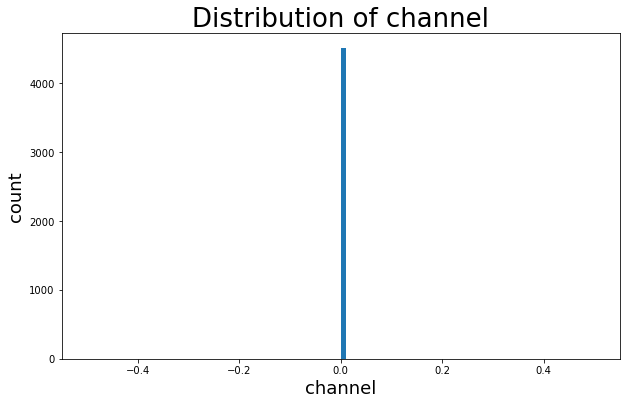

In [11]:
# get distribution of channel
fig = plt.figure(figsize=(10,6))
plt.hist(sabers_edge_df["channel"], bins = 100)
plt.title("Distribution of channel", fontsize=26)
plt.xlabel('channel', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

Only 1 channel makes sense, there is only a single piano in the midi track

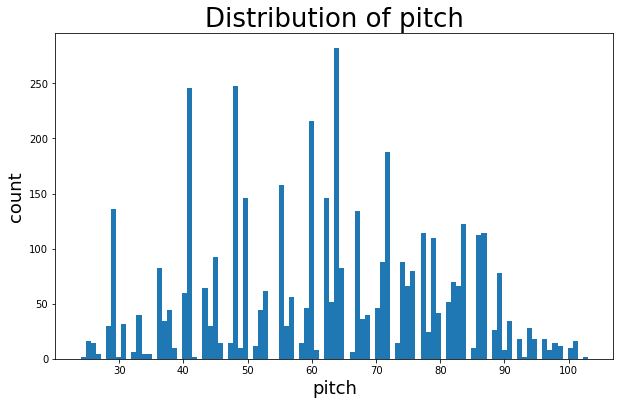

In [12]:
# get distribution of pitch
fig = plt.figure(figsize=(10,6))
plt.hist(sabers_edge_df["pitch"], bins = 100)
plt.title("Distribution of pitch", fontsize=26)
plt.xlabel('pitch', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

Pitch of keys according to: https://inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies
Should start around 20 for A0 (lowest key on the piano), which agrees with what's shown here.

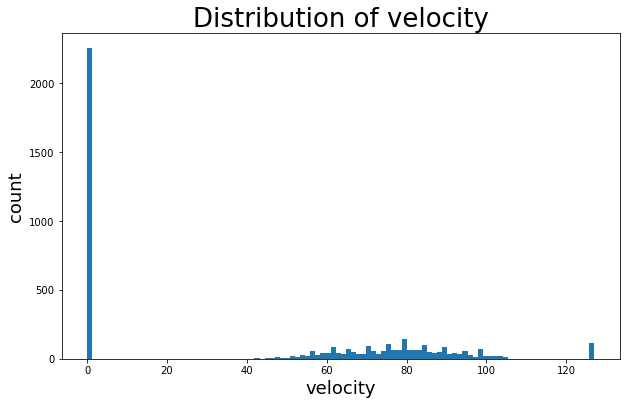

In [13]:
# get distribution of velocity
fig = plt.figure(figsize=(10,6))
plt.hist(sabers_edge_df["velocity"], bins = 100)
plt.title("Distribution of velocity", fontsize=26)
plt.xlabel('velocity', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.show()

In [14]:
# how many are 0? it looks like half have velocity 0
len(sabers_edge_df.loc[sabers_edge_df['velocity'] == 0])

2254

In [15]:
len(sabers_edge_df)

4508

This agrees with what's expected based on earlier. Great!